In [1]:
import logging
import pathlib
import pprint
import sys

import joblib
import numpy as np
import pandas as pd
import toml
import torch

sys.path.append("../ML_utils/")

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, parallel_backend
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNetCV, LogisticRegression, MultiTaskElasticNetCV

# import RepeatedKFold
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    LeaveOneOut,
    RepeatedKFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False
if in_notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

In [2]:
# read in the data
sc_file_path = pathlib.Path("../results/cleaned_sc_profile.parquet").resolve(
    strict=True
)
sc_endpoint_file_path = pathlib.Path(
    "../results/cleaned_endpoint_sc_profile.parquet"
).resolve(strict=True)

data_split_file_path = pathlib.Path("../results/data_splits.parquet").resolve(
    strict=True
)

sc_profile = pd.read_parquet(sc_file_path)
sc_endpoint_profile = pd.read_parquet(sc_endpoint_file_path)
data_split_df = pd.read_parquet(data_split_file_path)
print(f"sc_profile shape: {sc_profile.shape}")
print(f"sc_endpoint_profile shape: {sc_endpoint_profile.shape}")
print(f"data_split_df shape: {data_split_df.shape}")
data_split_df.head()

sc_profile shape: (145489, 2447)
sc_endpoint_profile shape: (31332, 284)
data_split_df shape: (12050, 3)


,index,data_split,data_x_or_y
0,7260,train_gt,X
1,7261,train_gt,X
2,7263,train_gt,X
3,7264,train_gt,X
4,7265,train_gt,X


In [3]:
# keep only the last timepoint
sc_profile["Metadata_Time"] = sc_profile["Metadata_Time"].astype("float64")
sc_profile = sc_profile[
    sc_profile["Metadata_Time"] == sc_profile["Metadata_Time"].max()
]
# drop Na values
sc_profile.dropna(inplace=True)
print(f"sc_profile shape after dropping NaN: {sc_profile.shape}")
sc_endpoint_profile.dropna(inplace=True)
print(f"sc_endpoint_profile shape after dropping NaN: {sc_endpoint_profile.shape}")
# hardcode the features that should exist in the y data
# this will be replaced in the future by an arg or config passed through
metadata_y_features = [x for x in sc_endpoint_profile.columns if "Metadata_" in x]
selected_y_features = ["Cytoplasm_Intensity_IntegratedIntensity_AnnexinV"]
sc_endpoint_profile = sc_endpoint_profile[metadata_y_features + selected_y_features]
print(
    f"sc_endpoint_profile shape after selecting features: {sc_endpoint_profile.shape}"
)

sc_profile shape after dropping NaN: (10274, 2447)
sc_endpoint_profile shape after dropping NaN: (29832, 284)
sc_endpoint_profile shape after selecting features: (29832, 25)


In [4]:
column_names = sc_endpoint_profile.columns
column_names = [x for x in column_names if "AnnexinV" in x and "Intensity" in x]
column_names
# sc_endpoint_profile = sc_endpoint_profile[metadata_y_features + column_names]

['Cytoplasm_Intensity_IntegratedIntensity_AnnexinV']

In [5]:
profile_data_splits_df = data_split_df.loc[data_split_df["data_x_or_y"] == "X"]
profile_data_splits_df
endpoint_data_splits_df = data_split_df.loc[data_split_df["data_x_or_y"] == "y"]
endpoint_data_splits_df
# replace the index with the index column
profile_data_splits_df = profile_data_splits_df.set_index(
    "index", drop=True, verify_integrity=True
)
endpoint_data_splits_df = endpoint_data_splits_df.set_index(
    "index", drop=True, verify_integrity=True
)
# remove the index name from profile_data_splits_df
profile_data_splits_df.index.name = None
# remove the index name from endpoint_data_splits_df
endpoint_data_splits_df.index.name = None

In [6]:
# get only indexes from sc_profile that are in the train_gt split
train_gt_X = sc_profile.loc[
    sc_profile.index.isin(
        profile_data_splits_df.loc[
            profile_data_splits_df["data_split"] == "train_gt"
        ].index
    )
]
train_gt_y = sc_endpoint_profile.loc[
    sc_endpoint_profile.index.isin(
        endpoint_data_splits_df.loc[
            endpoint_data_splits_df["data_split"] == "train_gt"
        ].index
    )
]

test_gt_X = sc_profile.loc[
    sc_profile.index.isin(
        profile_data_splits_df.loc[
            profile_data_splits_df["data_split"] == "holdout_gt"
        ].index
    )
]
test_gt_y = sc_endpoint_profile.loc[
    sc_endpoint_profile.index.isin(
        endpoint_data_splits_df.loc[
            endpoint_data_splits_df["data_split"] == "holdout_gt"
        ].index
    )
]

# assertion checks
print(f"train_gt_X shape: {train_gt_X.shape}, train_gt_y shape: {train_gt_y.shape}")
print(f"test_gt_X shape: {test_gt_X.shape}, test_gt_y shape: {test_gt_y.shape}")
assert train_gt_X.shape[0] == train_gt_y.shape[0]
assert test_gt_X.shape[0] == test_gt_y.shape[0]

train_gt_X shape: (1302, 2447), train_gt_y shape: (1302, 25)
test_gt_X shape: (561, 2447), test_gt_y shape: (561, 25)


In [7]:
# align the order of the Metadata_sc_unique_track_id between the x and y data
train_gt_X = train_gt_X.sort_values("Metadata_sc_unique_track_id")
train_gt_y = train_gt_y.sort_values("Metadata_sc_unique_track_id")
# reset the index
train_gt_X = train_gt_X.reset_index(drop=True)
train_gt_y = train_gt_y.reset_index(drop=True)
# check the order of the Metadata_sc_unique_track_id
assert (
    train_gt_X["Metadata_sc_unique_track_id"].values
    == train_gt_y["Metadata_sc_unique_track_id"].values
).all()
# align the order of the Metadata_sc_unique_track_id between the x and y data
test_gt_X = test_gt_X.sort_values("Metadata_sc_unique_track_id")
test_gt_y = test_gt_y.sort_values("Metadata_sc_unique_track_id")
# reset the index
test_gt_X = test_gt_X.reset_index(drop=True)
test_gt_y = test_gt_y.reset_index(drop=True)
# check the order of the Metadata_sc_unique_track_id
assert (
    test_gt_X["Metadata_sc_unique_track_id"].values
    == test_gt_y["Metadata_sc_unique_track_id"].values
).all()

In [8]:
# get metadata
metadata_X_cols = [x for x in train_gt_X.columns if "Metadata_" in x]
metadata_y_cols = [x for x in train_gt_y.columns if "Metadata_" in x]


train_gt_X_metadata = train_gt_X[metadata_X_cols]
train_gt_X.drop(columns=metadata_X_cols, inplace=True)
train_gt_y_metadata = train_gt_y[metadata_y_cols]
train_gt_y.drop(columns=metadata_y_cols, inplace=True)
test_gt_X_metadata = test_gt_X[metadata_X_cols]
test_gt_X.drop(columns=metadata_X_cols, inplace=True)
test_gt_y_metadata = test_gt_y[metadata_y_cols]
test_gt_y.drop(columns=metadata_y_cols, inplace=True)

In [9]:
# shuffle the data
shuffled_train_gt_X = train_gt_X.copy()
for col in shuffled_train_gt_X.columns:
    if col.startswith("Metadata_"):
        continue
    shuffled_train_gt_X[col] = np.random.permutation(shuffled_train_gt_X[col].values)
shuffled_train_gt_y = train_gt_y.copy()
for col in shuffled_train_gt_y.columns:
    if col.startswith("Metadata_"):
        continue
    shuffled_train_gt_y[col] = np.random.permutation(shuffled_train_gt_y[col].values)

In [10]:
# number of input features
n_features = train_gt_X.shape[1]
# number of output features
n_outputs = train_gt_y.shape[1]
# number of metadata features
n_metadata_features = train_gt_X_metadata.shape[1]

print(f"n_features: {n_features}")
print(f"n_outputs: {n_outputs}")
print(f"n_metadata_features: {n_metadata_features}")

n_features: 2409
n_outputs: 1
n_metadata_features: 38


In [11]:
train_gt_X.reset_index(drop=True, inplace=True)
train_gt_y.reset_index(drop=True, inplace=True)
train_gt_X = train_gt_X.values
train_gt_y = train_gt_y.values
test_gt_X.reset_index(drop=True, inplace=True)
test_gt_y.reset_index(drop=True, inplace=True)
test_gt_X = test_gt_X.values
test_gt_y = test_gt_y.values

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_gt_X = scaler.fit_transform(train_gt_X)
test_gt_X = scaler.transform(test_gt_X)
train_gt_y = scaler.fit_transform(train_gt_y)
test_gt_y = scaler.transform(test_gt_y)

In [13]:
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [14]:
train_gt_y = pd.DataFrame(train_gt_y, columns=column_names)
test_gt_y = pd.DataFrame(test_gt_y, columns=column_names)

Best alpha: 0.1
Best l1_ratio: 0.7
For training data:
Train MSE: 0.8381369321893374
Train R2: 1.0
For test data:
Test MSE: 1.6514384729773428
Test R2: 1.0


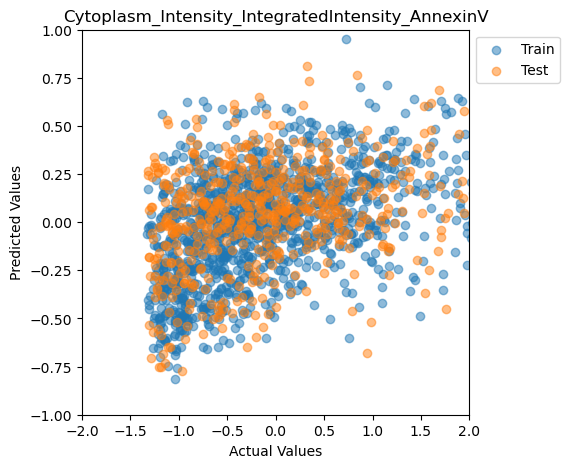

: 

In [ ]:
for col in train_gt_y.columns:
    train_gt_y_single_feature = train_gt_y[col].values
    test_gt_y_single_feature = test_gt_y[col].values
    model = ElasticNetCV(
        max_iter=1000,
        random_state=0,
        alphas=[0.01, 0.1, 1.0, 10.0],
        l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        cv=5,
    )
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        model.fit(train_gt_X, train_gt_y_single_feature)
    print("Best alpha:", model.alpha_)
    print("Best l1_ratio:", model.l1_ratio_)
    print("For training data:")
    train_y_pred = model.predict(train_gt_X)
    mse = mean_squared_error(train_gt_y_single_feature, train_y_pred)
    # get the r2 score of y vs y_pred
    r2 = model.score(train_gt_X, train_y_pred)
    print("Train MSE:", mse)
    print("Train R2:", r2)

    print("For test data:")
    test_y_pred = model.predict(test_gt_X)
    mse = mean_squared_error(test_gt_y_single_feature, test_y_pred)
    r2 = model.score(test_gt_X, test_y_pred)
    print("Test MSE:", mse)
    print("Test R2:", r2)

    plt.figure(figsize=(5, 5))
    plt.scatter(train_gt_y_single_feature, train_y_pred, alpha=0.5)
    # plt.plot([test_gt_y.min(), test_gt_y.max()], [test_gt_y.min(), test_gt_y.max()], 'k--', lw=2)
    plt.scatter(test_gt_y_single_feature, test_y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{col}")
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)
    # make legend out side of the plot
    plt.legend(["Train", "Test"], loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [16]:
# model_output_path = pathlib.Path(
#     "../models/Cells_Intensity_MeanIntensityEdge_AnnexinV.joblib"
# ).resolve()
# model_output_path.parent.mkdir(parents=True, exist_ok=True)
# dump(model, model_output_path)

# attempt to recreate the bulk model for sc